# 单卡GPU 进行 ChatGLM3-6B模型 LORA 高效微调
本 Cookbook 将带领开发者使用 `AdvertiseGen` 对 ChatGLM3-6B 数据集进行 lora微调，使其具备专业的广告生成能力。

## 硬件需求
显存：24GB及以上（推荐使用30系或A10等sm80架构以上的NVIDIA显卡进行尝试）
内存：16GB
RAM: 2.9 /16 GB
GPU RAM: 15.5/16.0 GB

## 0. 环境检查
首先，先检查代码的运行地址，确保运行地址处于 `finetune_demo` 中。
并且，确保已经安装了 `requirements.txt`中的依赖。

> 本 demo 中，不需要使用 deepspeed, mpi4py 两个依赖，如果您安装这两个依赖遇到问题，可以不安装这两个依赖。

In [1]:
!pwd

/home/overman/Workspace/ChatGLM3/finetune_demo


## 1. 准备数据集
我们使用 AdvertiseGen 数据集来进行微调。从 [Google Drive](https://drive.google.com/file/d/13_vf0xRTQsyneRKdD1bZIr93vBGOczrk/view?usp=sharing) 或者 [Tsinghua Cloud](https://cloud.tsinghua.edu.cn/f/b3f119a008264b1cabd1/?dl=1) 下载处理好的 AdvertiseGen 数据集，将解压后的 AdvertiseGen 目录放到本目录的 `/data/` 下, 例如。
> /media/zr/Data/Code/ChatGLM3/finetune_demo/data/AdvertiseGen

In [2]:
import json
from typing import Union
from pathlib import Path


def _resolve_path(path: Union[str, Path]) -> Path:
    return Path(path).expanduser().resolve()


def _mkdir(dir_name: Union[str, Path]):
    dir_name = _resolve_path(dir_name)
    if not dir_name.is_dir():
        dir_name.mkdir(parents=True, exist_ok=False)


def convert_adgen(data_dir: Union[str, Path], save_dir: Union[str, Path]):
    def _convert(in_file: Path, out_file: Path):
        _mkdir(out_file.parent)
        with open(in_file, encoding='utf-8') as fin:
            with open(out_file, 'wt', encoding='utf-8') as fout:
                for line in fin:
                    dct = json.loads(line)
                    sample = {'conversations': [{'role': 'user', 'content': dct['content']},
                                                {'role': 'assistant', 'content': dct['summary']}]}
                    fout.write(json.dumps(sample, ensure_ascii=False) + '\n')

    data_dir = _resolve_path(data_dir)
    save_dir = _resolve_path(save_dir)

    train_file = data_dir / 'train.json'
    if train_file.is_file():
        out_file = save_dir / train_file.relative_to(data_dir)
        _convert(train_file, out_file)

    dev_file = data_dir / 'dev.json'
    if dev_file.is_file():
        out_file = save_dir / dev_file.relative_to(data_dir)
        _convert(dev_file, out_file)


convert_adgen('data/AdvertiseGen', 'data/AdvertiseGen_fix')

## 2. 使用命令行开始微调,我们使用 lora 进行微调
接着，我们仅需要将配置好的参数以命令行的形式传参给程序，就可以使用命令行进行高效微调。

In [3]:
!CUDA_VISIBLE_DEVICES=0 NCCL_P2P_DISABLE="1" NCCL_IB_DISABLE="1" python finetune_hf.py  data/AdvertiseGen_fix  THUDM/chatglm3-6b  configs/lora.yaml

/home/overman/miniconda3/envs/chatglm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Setting eos_token is not supported, use the default one.
Setting pad_token is not supported, use the default one.
Setting unk_token is not supported, use the default one.
Loading checkpoint shards: 100%|██████████████████| 7/7 [00:03<00:00,  1.85it/s]
trainable params: 1,949,696 || all params: 6,245,533,696 || trainable%: 0.0312
--> Model

--> model has 1.949696M params

Setting num_proc from 16 back to 1 for the train split to disable multiprocessing as it only contains one shard.
Generating train split: 114599 examples [00:00, 1390855.71 examples/s]
Setting num_proc from 16 back to 1 for the validation split to disable multiprocessing as it only contains one shard.
Generating va

In [5]:
!CUDA_VISIBLE_DEVICES=0 NCCL_P2P_DISABLE="1" NCCL_IB_DISABLE="1" python inference_hf.py output/checkpoint-34000/ --prompt "类型#裙*版型#显瘦*材质#网纱*风格#性感*裙型#百褶*裙下摆#压褶*裙长#连衣裙*裙衣门襟#拉链*裙衣门襟#套头*裙款式#拼接*裙款式#拉链*裙款式#木耳边*裙款式#抽褶*裙款式#不规则"

/home/overman/miniconda3/envs/chatglm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████| 7/7 [00:01<00:00,  5.48it/s]
Setting eos_token is not supported, use the default one.
Setting pad_token is not supported, use the default one.
Setting unk_token is not supported, use the default one.
这款连衣裙采用不规则的裙摆设计，轻松打造出时尚的层次感，带来别致的视觉体验。套头拉链的门襟，方便穿脱，穿脱更加方便。百褶拼接的领口，性感迷人，凸显女性魅力。百褶的袖口，修饰手臂曲线，修饰手臂纤细。百褶的裙摆，百褶的层数丰富，轻盈飘逸，行走之间，飘逸灵动。网纱的裙摆，轻盈飘逸，带出浪漫气息。腰间的木耳边装饰，修身显瘦。


In [7]:
!CUDA_VISIBLE_DEVICES=0 NCCL_P2P_DISABLE="1" NCCL_IB_DISABLE="1" python inference_hf.py output/checkpoint-500/ --prompt "类型#裙*版型#显瘦*材质#网纱*风格#性感*裙型#百褶*裙下摆#压褶*裙长#连衣裙*裙衣门襟#拉链*裙衣门襟#套头*裙款式#拼接*裙款式#拉链*裙款式#木耳边*裙款式#抽褶*裙款式#不规则"

/home/overman/miniconda3/envs/chatglm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████| 7/7 [00:01<00:00,  5.67it/s]
Setting eos_token is not supported, use the default one.
Setting pad_token is not supported, use the default one.
Setting unk_token is not supported, use the default one.
这款连衣裙是款性感的包臀连衣裙，精选优质纯棉面料，触感柔软亲肤，穿着舒适不刺激。而网纱的拼接，让整体更具时尚感，更显青春活力。而裙摆的木耳边装饰，让整体更显气质。而拉链的装饰，更是方便实用。而袖口的不规则设计，更显个性。


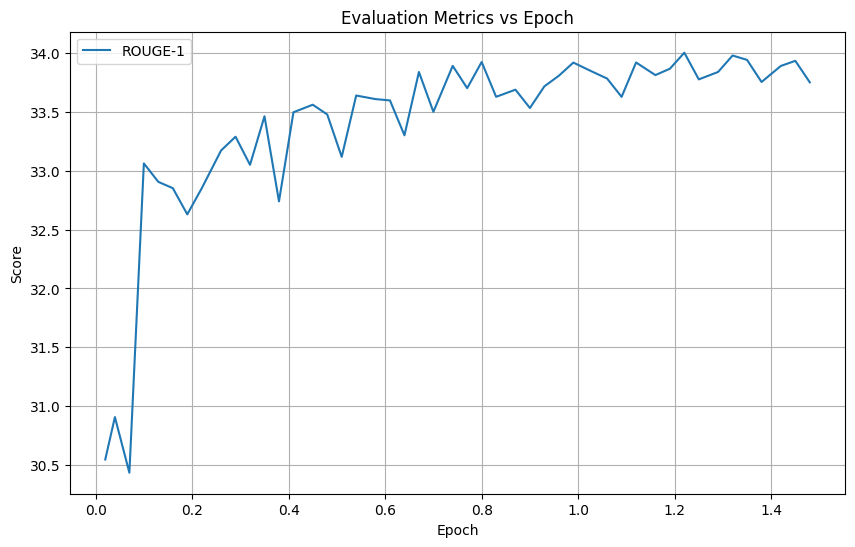

In [5]:
import matplotlib.pyplot as plt

epochs = [0.02, 0.04, 0.07, 0.1, 0.13, 0.16, 0.19, 0.22, 0.26, 0.29, 0.32, 0.35, 0.38, 0.41, 0.45, 0.48, 0.51, 0.54, 0.58, 0.61, 0.64, 0.67, 0.7, 0.74, 0.77, 0.8, 0.83, 0.87, 0.9, 0.93, 0.96, 0.99, 1.03, 1.06, 1.09, 1.12, 1.16, 1.19, 1.22, 1.25, 1.29, 1.32, 1.35, 1.38, 1.42, 1.45, 1.48]

rouge_1 = [30.545274, 30.90562, 30.432632, 33.063156, 32.905928, 32.8526, 32.629842, 32.851914, 33.172854, 33.290186, 33.05089, 33.463974, 32.74026, 33.498024, 33.562138, 33.479206, 33.11846, 33.640366, 33.609974, 33.59864, 33.302082, 33.840458, 33.501544, 33.892548, 33.703014, 33.925366, 33.629424, 33.689936, 33.534428, 33.718376, 33.808748, 33.920456, 33.841712, 33.784576, 33.628942, 33.921394, 33.81411, 33.8681, 34.004326, 33.777452, 33.84095, 33.98052, 33.94339, 33.75536, 33.89187, 33.935446, 33.752542]

rouge_2 = [6.493294, 6.414098, 6.519932, 7.18573, 7.021152, 7.132914, 6.997162, 7.37077, 7.153266, 7.621336, 7.163582, 7.386136, 7.257528, 7.499584, 7.528214, 7.446986, 7.438784, 7.45353, 7.556992, 7.49762, 7.369766, 7.76466, 7.450398, 7.617546, 7.545998, 7.739288, 7.5737, 7.626966, 7.33872, 7.639386, 7.789578, 7.724292, 7.625366, 7.589372, 7.637768, 7.715382, 7.551762, 7.64322, 7.585352, 7.522816, 7.55681, 7.649188, 7.5851, 7.59498, 7.547922, 7.56998, 7.529678]

rouge_l = [23.984524, 23.438138, 22.736814, 25.100126, 25.142392, 25.2631, 24.925792, 25.452806, 25.326284, 25.761908, 25.340775, 25.705012, 25.23583, 25.888076, 25.83213, 25.753925, 25.535948, 25.84405, 25.981374, 25.844914, 25.58185, 26.183784, 25.7259, 26.05924, 25.956816, 26.199724, 25.937008, 26.037606, 25.668404, 26.03469, 26.25103, 26.169966, 26.056482, 25.998402, 26.027034, 26.16504, 25.956508, 26.059866, 26.057232, 25.900264, 25.951862, 26.08501, 25.99629, 25.986202, 25.946598, 26.016956, 25.882006]

bleu_4 = [0.0313978463216029, 0.0311746094535276, 0.0316031691257984, 0.0317454604915017, 0.0320855737021205, 0.032412977461145, 0.0326797535761837, 0.0330479625165485, 0.0339907312348091, 0.0341639861457152, 0.0347145202765052, 0.0356954633521293, 0.0352665660345476, 0.035837689651413, 0.0358585196828247, 0.0359158924977685, 0.0357615768606609, 0.0362173154831184, 0.0364369854719463, 0.0367390333805162, 0.0367691594261983, 0.0374553829519436, 0.0373254155573388, 0.0375599533746877, 0.0377380257074797, 0.0379009693129077, 0.0377680554727208, 0.0380844778711873, 0.0377294831841843, 0.0381429043146768, 0.0384694174006116, 0.0383620505851305, 0.038420840938081, 0.0385612771664427, 0.0386711622328767, 0.0389278106510973, 0.0386803274385714, 0.0387957743035923, 0.0389105923481831, 0.0386614346323162, 0.0390449289210173, 0.0393208910687729, 0.0391448581204664, 0.0391930543617299, 0.0393096445187557, 0.0394025146020372, 0.0374406822848336]

plt.figure(figsize=(10, 6))
plt.plot(epochs, rouge_1, label='ROUGE-1')
#plt.plot(epochs, rouge_2, label='ROUGE-2')
#plt.plot(epochs, rouge_l, label='ROUGE-L')
#plt.plot(epochs, bleu_4, label='BLEU-4')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs Epoch')
plt.legend()
plt.grid()
plt.show()